<a href="https://colab.research.google.com/github/gabrielgranados97/IA_Tarea4/blob/main/Tarea4_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gabriel Fernando Granados Álvarez

**Tarea 4**

**Tópicos IA**

**Ejercicio acciones de Apple**

In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,8

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam

Versión de Tensorflow:  2.8.0


In [ ]:
!pip install yfinance

In [ ]:
# import modules
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
  
# initialize parameters
start_date = datetime(2006, 1, 1)
end_date = datetime(2022, 5, 6)
  
# get the data
df = yf.download('AAPL', start = start_date,
                   end = end_date)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.282592,807234400
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.289310,619603600
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.271294,449422400
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.329924,704457600
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.322290,675040800
...,...,...,...,...,...,...
2022-04-29,161.839996,166.199997,157.250000,157.649994,157.418701,131587100
2022-05-02,156.710007,158.229996,153.270004,157.960007,157.728256,123055300
2022-05-03,158.149994,160.710007,156.320007,159.479996,159.246017,88966500


In [ ]:
data = pd.DataFrame(df[['Close']])

In [ ]:
#Visualización
# plot
len_data = len(data)
len_train = int(len_data*0.8) # 80%  = 3019
len_test = len_data- len_train # 20% = 2415
print (len_data, '=', len_train, '+',len_test)

4114 = 3291 + 823


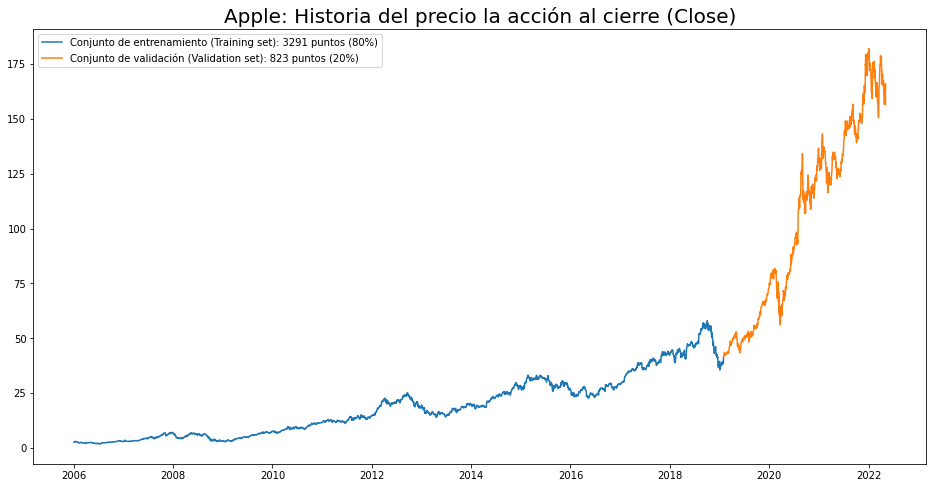

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("Apple: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

In [ ]:
#Crear datos de entrenamiento
dataset = data.values


# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
tf.random.set_seed(100)

In [ ]:
#
# hiperparámetros para crear las secuencias
past_history = 60 # tamaño secuencias de entrada
future_target = 3 # días adelante
TRAIN_SPLIT = int(len_data*0.8) #2415: nuḿer0 de datos entreno

# secuencias de entrenamiento
X_train, y_train = univariate_data(dataset, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
#
#secuencias de validación
# No se usará ningún dato que el modelo haya visto
X_test, y_test = univariate_data(dataset, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

3291
(3231, 60, 1)
(3231,)
(760, 60, 1)
(760,)


In [ ]:
#Modelo LSTM
# shapes
input_shape = (X_train.shape[1], X_train.shape[2])
units = 64

# layers
inputs = Input(input_shape)
#x = Dropout(0.0, name= 'Dropout_01')(inputs)
#x = LSTM(units=units, name='LSTM_layer')(x)
x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
x = Dropout(0.4, name= 'Dropout_02')(x)
x = LSTM(units=units//2, name='LSTM_layer_2')(x)
x = Dropout(0.4, name= 'Dropout_03')(x)
outputs = Dense(1)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 LSTM_layer (LSTM)           (None, 60, 64)            16896     
                                                                 
 Dropout_02 (Dropout)        (None, 60, 64)            0         
                                                                 
 LSTM_layer_2 (LSTM)         (None, 32)                12416     
                                                                 
 Dropout_03 (Dropout)        (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non

In [ ]:
#compila
model_01.compile(loss='mean_squared_error',
  optimizer=Adam(0.001))

In [ ]:
#Entrenamiento
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
tf.random.set_seed(100)
history = model_01.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/15
91/91 [==============================] - 9s 18ms/step - loss: 5.2574e-04 - val_loss: 7.8816e-04
Epoch 2/15
91/91 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 3/15
91/91 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 4/15
91/91 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 5/15
91/91 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/15
91/91 [==============================] - 1s 9ms/step - loss: 5.7861e-04 - val_loss: 2.3853e-04
Epoch 7/15
91/91 [==============================] - 1s 9ms/step - loss: 2.7329e-04 - val_loss: 2.1670e-04
Epoch 8/15
91/91 [==============================] - 1s 9ms/step - loss: 2.0084e-04 - val_loss: 1.7785e-04
Epoch 9/15
91/91 [==============================] - 1s 9ms/step - loss: 2.2650e-04 - val_loss: 2.1876e-04
Epoch 10/15
91/91 [==============================] - 1s 9ms/step - loss: 1.92

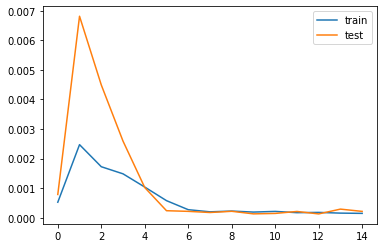

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

**Predicciones**

In [ ]:
# predictions
prediction = model_01.predict(X_test)
#prediction = scaler.inverse_transform(prediction)

In [ ]:
y_train_p = y_train# np.squeeze(y_train, axis=-1)
y_test_p = y_test #np.squeeze(y_test, axis=-1)
y_pred_p = np.squeeze(prediction, axis=-1)

print(y_train_p.shape)
print(y_test_p.shape)
print(y_pred_p.shape)

k=0
for i,j in zip(y_test_p, y_pred_p):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

(3231,)
(760,)
(760,)
0.2801207380024998 0.2615862 0.018534548732480283
0.2837278426532533 0.26193106 0.02179678090856335
0.2791912196033195 0.26161718 0.01757403591801676
0.2713943492432815 0.26220706 0.009187288190959098
0.2714498337162654 0.26303485 0.008414983357302397
0.2684254324624428 0.26423928 0.0041861510465034946
0.2635142204199677 0.26512045 -0.0016062262620086254
0.24761526217548024 0.26504987 -0.017434612607082012
0.25169405893879687 0.264486 -0.012791955904190189
0.25482945030778725 0.26343262 -0.008603171648084329


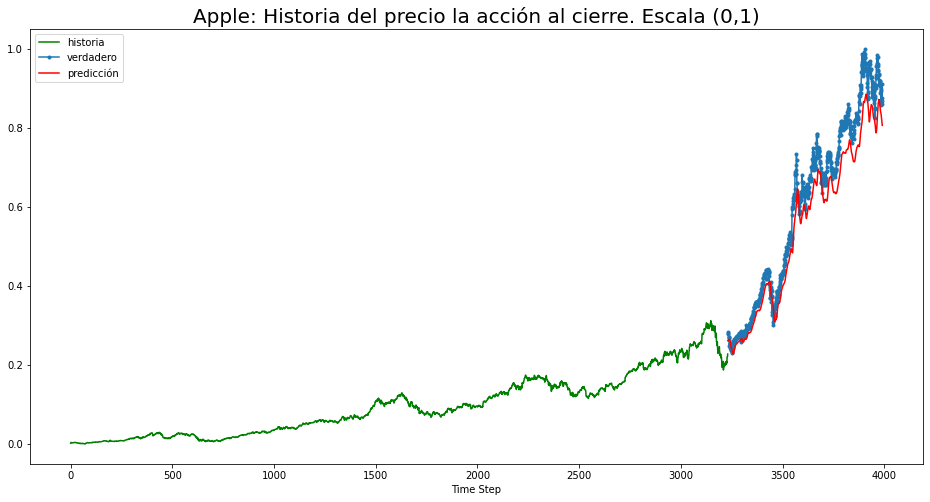

In [ ]:
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', label="historia")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Apple: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();

In [ ]:
#Escala original
y_pred_or = scaler.inverse_transform(y_pred_p.reshape(-1,1))
y_test_or = scaler.inverse_transform(y_test_p.reshape(-1,1))

In [ ]:
k=0
for i,j in zip(y_test_or, y_pred_or):
    print (i,j, i-j)
    k+=1
    if k==10:
        break

[52.28749847] [48.947567] [3.33993149]
[52.9375] [49.009712] [3.92778778]
[52.11999893] [48.95315] [3.16684723]
[50.71500015] [49.05945] [1.65555191]
[50.72499847] [49.20862] [1.51638031]
[50.18000031] [49.425655] [0.75434494]
[49.29499817] [49.584442] [-0.28944397]
[46.43000031] [49.571724] [-3.14172363]
[47.16500092] [49.470116] [-2.30511475]
[47.72999954] [49.280296] [-1.55029678]


In [ ]:
rmsLSTM = np.sqrt(np.mean(np.power(y_pred_or-y_test_or,2)))
print(rmsLSTM )

11.261160197971007


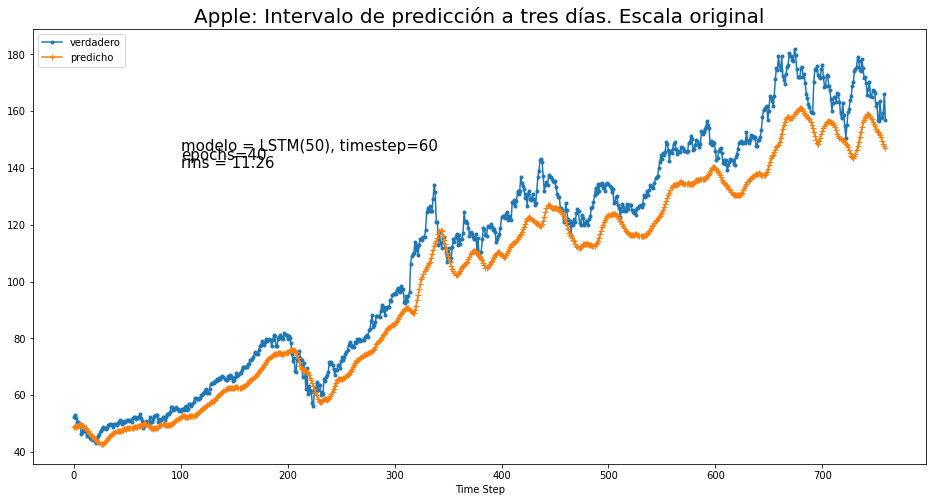

In [ ]:
plt.plot(np.arange(0, len(y_test_or)), y_test_or, marker='.', label="verdadero")
plt.plot(np.arange(0, len(y_test_or)), y_pred_or, marker='+', label="predicho")
plt.xlabel('Time Step')
plt.annotate("rms = "+str(round(rmsLSTM,2)) , xy=(100, 140), size = 15)
plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
plt.annotate("epochs=40" , xy=(100, 143), size = 15)
plt.title("Apple: Intervalo de predicción a tres días. Escala original", size = 20)
plt.legend()
plt.show();